<a href="https://colab.research.google.com/github/varshil009/FaceInpainting/blob/main/Occlusion_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import os
import torch
from torchvision import transforms
import numpy as np
import random
from PIL import Image, ImageDraw, ImageFilter
import cv2

In [ ]:
from google.colab import drive
drive.mount("/content/MyDrive")

Mounted at /content/MyDrive


In [ ]:
parentf = "/content/MyDrive/MyDrive/CelebA_subset"

In [ ]:
classes = os.listdir(parentf)

In [ ]:
classes

['8968',
 '6568',
 '2820',
 '3745',
 '3227',
 '3782',
 '3699',
 '9256',
 '4887',
 '9152',
 'occluded_dataset_BIG_NEW']

## faces

8968 (218, 178, 3)
6568 (218, 178, 3)
2820 (218, 178, 3)
3745 (218, 178, 3)
3227 (218, 178, 3)
3782 (218, 178, 3)
3699 (218, 178, 3)
9256 (218, 178, 3)
4887 (218, 178, 3)
9152 (218, 178, 3)


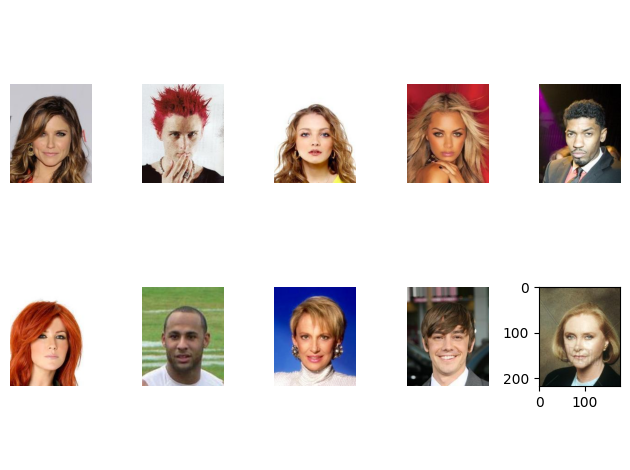

In [ ]:
for i, c in enumerate(classes[:-1]):
    classpath = os.path.join(parentf, c)
    ims = os.listdir(classpath)
    impath = os.path.join(classpath, ims[0])
    print(c, plt.imread(impath).shape)
    plt.axis("off")
    plt.subplot(2, 5, i+1)
    plt.imshow(plt.imread(impath))

plt.tight_layout()
plt.show()


In [ ]:
for i, c in enumerate(classes):
    classpath = os.path.join(parentf, c)
    ims = os.listdir(classpath)
    print("number of images availabel for class {} is {}".format(c, len(ims)))

number of images availabel for class 8968 is 32
number of images availabel for class 6568 is 31
number of images availabel for class 2820 is 35
number of images availabel for class 3745 is 34
number of images availabel for class 3227 is 35
number of images availabel for class 3782 is 35
number of images availabel for class 3699 is 34
number of images availabel for class 9256 is 32
number of images availabel for class 4887 is 31
number of images availabel for class 9152 is 32
number of images availabel for class occluded_dataset_BIG_NEW is 11


In [ ]:
y = []
for x in os.scandir(parentf):
    y.append(x.name)
sorted(y)

['2820',
 '3227',
 '3699',
 '3745',
 '3782',
 '4887',
 '6568',
 '8968',
 '9152',
 '9256',
 'occluded_dataset_BIG_NEW']

In [ ]:
"""class DatasetOccluder:
    def __init__(self,
                 input_root_dir,
                 output_root_dir,
                 max_occlusions=3,
                 min_occlusion_size=0.05,
                 max_occlusion_size=0.3):
        """
        Generate occluded dataset from input directory

        Parameters:
        - input_root_dir: Source dataset directory
        - output_root_dir: Destination for occluded images
        - max_occlusions: Maximum number of occlusions per image
        - min_occlusion_size: Minimum occlusion size as a fraction of image
        - max_occlusion_size: Maximum occlusion size as a fraction of image
        """
        self.input_root_dir = input_root_dir
        self.output_root_dir = output_root_dir
        self.max_occlusions = max_occlusions
        self.min_occlusion_size = min_occlusion_size
        self.max_occlusion_size = max_occlusion_size

        # Ensure output directory exists
        os.makedirs(output_root_dir, exist_ok=True)

    def occlude_image(self, image):
        """
        Apply advanced random occlusions to an image
        """
        np_image = np.array(image)
        height, width, _ = np_image.shape

        # Determine number of occlusions
        num_occlusions = random.randint(1, self.max_occlusions)

        # Track placed occlusions to prevent overlap
        placed_occlusions = []

        for _ in range(num_occlusions):
            # Randomly choose occlusion type
            occlusion_type = random.choice(["noise", "blur", "cutout", "polygon"])

            # Calculate dynamic patch size
            min_size = int(min(height, width) * self.min_occlusion_size)
            max_size = int(min(height, width) * self.max_occlusion_size)
            patch_size = random.randint(min_size, max_size)

            # Random position
            x = random.randint(0, width - patch_size)
            y = random.randint(0, height - patch_size)

            # Apply occlusion based on type
            if occlusion_type == "noise":
                # Random noise patch
                noise_patch = np.random.randint(0, 256, (patch_size, patch_size, 3), dtype=np.uint8)
                np_image[y:y + patch_size, x:x + patch_size] = noise_patch

            elif occlusion_type == "blur":
                # Gaussian blur patch
                patch = Image.fromarray(np_image[y:y + patch_size, x:x + patch_size])
                blurred_patch = patch.filter(ImageFilter.GaussianBlur(radius=5))
                np_image[y:y + patch_size, x:x + patch_size] = np.array(blurred_patch)

            elif occlusion_type == "cutout":
                # Simple rectangular cutout with color variation
                cutout_color = np.random.randint(0, 256, 3)
                np_image[y:y + patch_size, x:x + patch_size] = cutout_color

            elif occlusion_type == "polygon":
                # Create a polygon mask
                from PIL import ImageDraw
                mask = Image.new('L', (patch_size, patch_size), 0)
                draw = ImageDraw.Draw(mask)

                # Random polygon with fewer points
                num_points = random.randint(3, 5)
                poly_points = [
                    (random.randint(0, patch_size), random.randint(0, patch_size))
                    for _ in range(num_points)
                ]
                draw.polygon(poly_points, fill=255)

                # Convert mask to numpy and apply to image
                np_mask = np.array(mask) / 255.0
                polygon_color = np.random.randint(0, 256, 3)
                patch_area = np_image[y:y + patch_size, x:x + patch_size]
                patch_area = patch_area * (1 - np_mask[:,:,np.newaxis]) + polygon_color * np_mask[:,:,np.newaxis]
                np_image[y:y + patch_size, x:x + patch_size] = patch_area.astype(np.uint8)

        return Image.fromarray(np_image)

    def generate_occluded_dataset(self, num_occlusions_per_image=20):
        """
        Generate occluded versions of entire dataset

        Parameters:
        - num_occlusions_per_image: Number of occluded versions to generate per image
        """
        # Iterate through input dataset classes
        for class_name in os.listdir(self.input_root_dir):
            class_input_path = os.path.join(self.input_root_dir, class_name)

            # Skip if not a directory
            if not os.path.isdir(class_input_path):
                continue

            # Create corresponding output class directory
            class_output_path = os.path.join(self.output_root_dir, class_name)
            os.makedirs(class_output_path, exist_ok=True)

            # Iterate through images in the class
            for i, img_name in enumerate(os.listdir(class_input_path)):
                # Full path to input image
                img_path = os.path.join(class_input_path, img_name)

                # Skip if not an image file
                if not img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    continue

                # Open original image
                try:
                    original_image = Image.open(img_path).convert('RGB')
                except Exception as e:
                    print(f"Error processing {img_path}: {e}")
                    continue

                # Generate multiple occluded versions
                for j in range(num_occlusions_per_image):
                    # Create occluded image
                    occluded_image = self.occlude_image(original_image)

                    # Generate output filename
                    output_filename = f"{class_name}_{i}_{j}.jpg"
                    output_path = os.path.join(class_output_path, output_filename)

                    # Save occluded image
                    occluded_image.save(output_path)
                    print(f"Saved: {output_path}")"""

In [ ]:
def apply_partial_occlusion(np_image, x, y, w, h):
    def random_patch_occlusion(image, x, y, w, h):
        # Randomly choose patch size (smaller than face region)
        patch_width = random.randint(w//4, w//2)
        patch_height = random.randint(h//4, h//2)

        # Randomly position the patch within the face region
        patch_x = random.randint(x, x+w-patch_width)
        patch_y = random.randint(y, y+h-patch_height)

        # Random patch color
        patch_color = np.random.randint(0, 256, 3)

        # Apply patch
        image[patch_y:patch_y+patch_height, patch_x:patch_x+patch_width] = patch_color
        return image

    def random_blur_occlusion(image, x, y, w, h):
        # Randomly choose blur region
        blur_width = random.randint(w//4, w//2)
        blur_height = random.randint(h//4, h//2)

        # Randomly position the blur within the face region
        blur_x = random.randint(x, x+w-blur_width)
        blur_y = random.randint(y, y+h-blur_height)

        # Extract region to blur
        face_subregion = image[blur_y:blur_y+blur_height, blur_x:blur_x+blur_width]

        # Apply different levels of blur
        blur_intensity = random.choice([(11,11), (15,15), (21,21)])
        blurred_region = cv2.GaussianBlur(face_subregion, blur_intensity, 0)

        # Replace subregion with blurred version
        image[blur_y:blur_y+blur_height, blur_x:blur_x+blur_width] = blurred_region
        return image

    def random_mask_occlusion(image, x, y, w, h):
        # Create a partial mask
        mask = np.zeros((h, w), dtype=np.uint8)
        mask_color = np.random.randint(0, 256, 3)

        # Randomly choose mask type
        mask_type = random.choice(['triangle', 'irregular', 'diagonal'])

        if mask_type == 'triangle':
            # Random triangle within face region
            points = [
                (random.randint(0, w), random.randint(0, h)),
                (random.randint(0, w), random.randint(0, h)),
                (random.randint(0, w), random.randint(0, h))
            ]
            cv2.fillPoly(mask, [np.array(points)], 255)

        elif mask_type == 'irregular':
            # Irregular polygon with fewer points
            points = [
                (random.randint(0, w), random.randint(0, h)) for _ in range(3)
            ]
            cv2.fillPoly(mask, [np.array(points)], 255)

        else:  # diagonal
            # Diagonal mask covering part of the face
            cv2.line(mask, (0, 0), (w, h), 255, random.randint(5, 15))

        # Apply mask to a portion of the face region
        masked_region = np.where(mask[:,:,np.newaxis] == 255, mask_color, image[y:y+h, x:x+w])
        image[y:y+h, x:x+w] = masked_region
        return image

    def random_shadow_occlusion(image, x, y, w, h):
        # Create a partial shadow
        shadow_mask = np.zeros_like(image[y:y+h, x:x+w])

        # Random shadow configuration
        shadow_type = random.choice(['diagonal', 'corner', 'gradient'])

        if shadow_type == 'diagonal':
            cv2.line(shadow_mask, (0, 0), (w, h), (0, 0, 0), random.randint(5, 15))

        elif shadow_type == 'corner':
            cv2.rectangle(shadow_mask,
                          (random.randint(0, w//2), random.randint(0, h//2)),
                          (w, h),
                          (0, 0, 0),
                          -1)

        else:  # gradient shadow
            gradient = np.linspace(0, 1, h)[:, np.newaxis]
            shadow_mask = (gradient * 255).astype(np.uint8)
            shadow_mask = np.repeat(shadow_mask, w, axis=1)
            shadow_mask = np.stack([shadow_mask]*3, axis=2)

        # Blend shadow with original region
        shadow_mask = cv2.addWeighted(
                                      shadow_mask, random.uniform(0.3, 0.7),
                                      image[y:y+h, x:x+w],
                                      random.uniform(0.5, 0.8),
                                      0)

        image[y:y+h, x:x+w] = shadow_mask
        return image

    occlusion_method = random.choice([
        random_patch_occlusion,
        random_mask_occlusion
    ])

    return occlusion_method(np_image, x, y, w, h)

In [ ]:
class FaceOccluder:
    def __init__(self,
                 input_root_dir,
                 output_root_dir,
                 occlusion_types=['patch', 'blur', 'mask', 'shadow']):
        """
        Generate face-specific occlusions

        Parameters:
        - input_root_dir: Source dataset directory
        - output_root_dir: Destination for occluded images
        - occlusion_types: Types of face occlusions to apply
        """
        self.input_root_dir = input_root_dir
        self.output_root_dir = output_root_dir
        self.occlusion_types = occlusion_types

        # Ensure output directory exists
        os.makedirs(output_root_dir, exist_ok=True)

    def detect_face(self, image):
        """
        Detect face regions using Haar Cascade
        """
        # Load pre-trained face detector
        face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

        # Convert to grayscale for detection
        gray = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2GRAY)

        # Detect faces
        faces = face_cascade.detectMultiScale(gray, 1.1, 4)
        return faces

    def occlude_face(self, image):
        """
        Apply occlusions specifically targeting face regions
        """
        # Convert PIL Image to numpy array
        np_image = np.array(image)

        # Detect faces
        faces = self.detect_face(image)

        # If no faces detected, return original image
        if len(faces) == 0:
            return Image.fromarray(np_image)

        # Choose a random face if multiple detected
        x, y, w, h = faces[0]

        # Apply chosen occlusion method
        return Image.fromarray(apply_partial_occlusion(np_image, x, y, w, h))


    def generate_occluded_dataset(self, num_occlusions_per_image=20):
        """
        Generate occluded versions of entire dataset
        """
        # Iterate through input dataset classes
        for class_name in os.listdir(self.input_root_dir):
            class_input_path = os.path.join(self.input_root_dir, class_name)

            # Skip if not a directory
            if not os.path.isdir(class_input_path):
                continue

            # Create corresponding output class directory
            class_output_path = os.path.join(self.output_root_dir, class_name)
            os.makedirs(class_output_path, exist_ok=True)

            # Iterate through images in the class
            for i, img_name in enumerate(os.listdir(class_input_path)):
                # Full path to input image
                img_path = os.path.join(class_input_path, img_name)

                # Skip if not an image file
                if not img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    continue

                # Open original image
                try:
                    original_image = Image.open(img_path).convert('RGB')
                except Exception as e:
                    print(f"Error processing {img_path}: {e}")
                    continue

                # Generate multiple occluded versions
                for j in range(num_occlusions_per_image):
                    # Create occluded image
                    occluded_image = self.occlude_face(original_image)
                    #plt.imshow(occluded_image)
                    #plt.show()
                    # Generate output filename
                    output_filename = f"{class_name}_{i}_{j}.jpg"
                    output_path = os.path.join(class_output_path, output_filename)

                    # Save occluded image
                    occluded_image.save(output_path)
                    if j % 5 == 0:
                        print(f"Saved: {output_path}")

"""def main():
    # Configure paths
    input_root_dir = '/path/to/input/dataset'   # Replace with your input dataset path
    output_root_dir = '/path/to/output/occluded_dataset'  # Replace with your desired output path

    # Create face occluder
    occluder = FaceOccluder(
        input_root_dir=input_root_dir,
        output_root_dir=output_root_dir
    )

    # Generate occluded dataset
    occluder.generate_occluded_dataset(num_occlusions_per_image=5)

if __name__ == '__main__':
    main()"""

"def main():\n    # Configure paths\n    input_root_dir = '/path/to/input/dataset'   # Replace with your input dataset path\n    output_root_dir = '/path/to/output/occluded_dataset'  # Replace with your desired output path\n\n    # Create face occluder\n    occluder = FaceOccluder(\n        input_root_dir=input_root_dir,\n        output_root_dir=output_root_dir\n    )\n\n    # Generate occluded dataset\n    occluder.generate_occluded_dataset(num_occlusions_per_image=5)\n\nif __name__ == '__main__':\n    main()"

In [ ]:
random.seed(42)

# Configure paths
input_root_dir = parentf   # Replace with your input dataset path
output_root_dir = parentf + '/occluded_dataset_BIG_NEW'  # Replace with your desired output path

# Create occluder
occluder = FaceOccluder(
    input_root_dir=input_root_dir,
    output_root_dir=output_root_dir
)

# Generate occluded dataset
occluder.generate_occluded_dataset(num_occlusions_per_image=20)

Saved: /content/MyDrive/MyDrive/CelebA_subset/occluded_dataset_BIG_NEW/8968/8968_0_0.jpg
Saved: /content/MyDrive/MyDrive/CelebA_subset/occluded_dataset_BIG_NEW/8968/8968_0_5.jpg
Saved: /content/MyDrive/MyDrive/CelebA_subset/occluded_dataset_BIG_NEW/8968/8968_0_10.jpg
Saved: /content/MyDrive/MyDrive/CelebA_subset/occluded_dataset_BIG_NEW/8968/8968_0_15.jpg
Saved: /content/MyDrive/MyDrive/CelebA_subset/occluded_dataset_BIG_NEW/8968/8968_1_0.jpg
Saved: /content/MyDrive/MyDrive/CelebA_subset/occluded_dataset_BIG_NEW/8968/8968_1_5.jpg
Saved: /content/MyDrive/MyDrive/CelebA_subset/occluded_dataset_BIG_NEW/8968/8968_1_10.jpg
Saved: /content/MyDrive/MyDrive/CelebA_subset/occluded_dataset_BIG_NEW/8968/8968_1_15.jpg
Saved: /content/MyDrive/MyDrive/CelebA_subset/occluded_dataset_BIG_NEW/8968/8968_2_0.jpg
Saved: /content/MyDrive/MyDrive/CelebA_subset/occluded_dataset_BIG_NEW/8968/8968_2_5.jpg
Saved: /content/MyDrive/MyDrive/CelebA_subset/occluded_dataset_BIG_NEW/8968/8968_2_10.jpg
Saved: /content/

In [ ]:
# Define destination folder
#save_dir = parentf + "/occluded_samples"
#os.mkdir(save_dir)

FileExistsError: [Errno 17] File exists: '/content/MyDrive/MyDrive/CelebA_subset/occluded_samples'

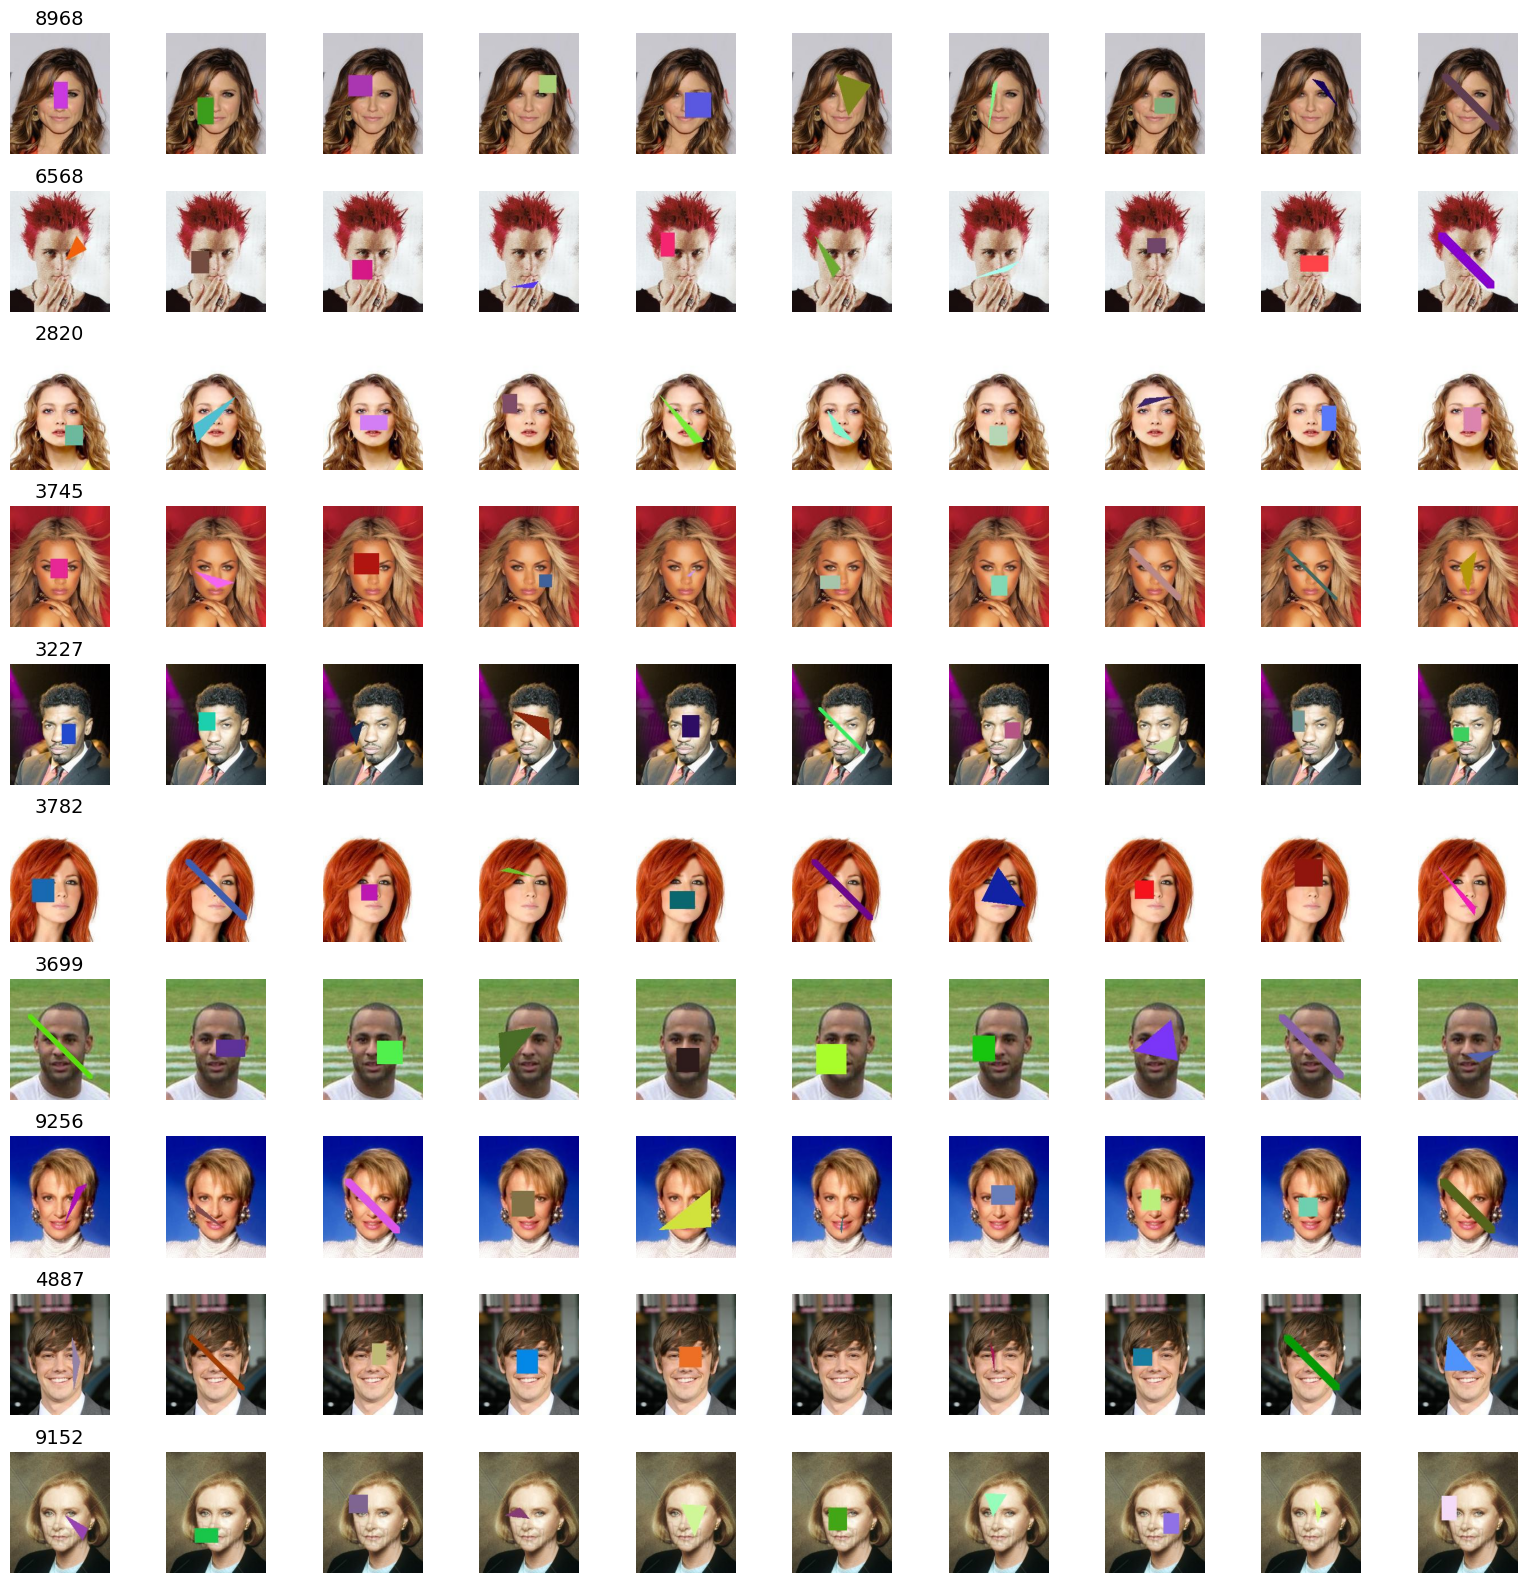

In [ ]:
files = "/content/MyDrive/MyDrive/" + "/occluded_dataset_BIG_NEW"
all_folders = list(os.scandir(files))  # Get all folders

plt.figure(figsize=(20, 20))  # Increase figure size
image_count = 0  # Track subplot index

for i, folder in enumerate(all_folders):
    if not folder.is_dir():
        continue  # Skip non-folder files

    for j in range(10):
        image_path = os.path.join(files, folder.name, f"{folder.name}_0_{j}.jpg")

        if not os.path.exists(image_path):
            print(f"Missing file: {image_path}")
            continue  # Skip missing images

        plt.subplot(len(all_folders), 10, image_count + 1)  # Ensure correct grid layout
        plt.imshow(plt.imread(image_path))
        plt.axis("off")  # Hide axes
        plt.title(folder.name if j == 0 else "", fontsize=14)  # Bigger title once per class

        image_count += 1  # Increase subplot index

plt.subplots_adjust(wspace=0.1, hspace=0.3)  # Adjust spacing
plt.show()
